Size of the dataset: (146160, 9)
Shape of X_train: (109620, 8), Shape of X_test: (36540, 8), Shape of y_train: (109620,), Shape of y_test: (36540,)


Accuracy: 0.9653804050355774


Classification Report:

               precision    recall  f1-score   support

no snowcover       0.93      0.92      0.93      8693
   snowcover       0.98      0.98      0.98     27847

    accuracy                           0.97     36540
   macro avg       0.95      0.95      0.95     36540
weighted avg       0.97      0.97      0.97     36540



Confusion matrix:

 [[ 8010   683]
 [  582 27265]]




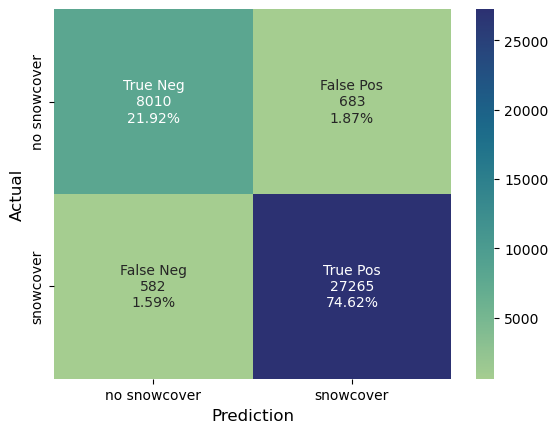



SHAP summary plot


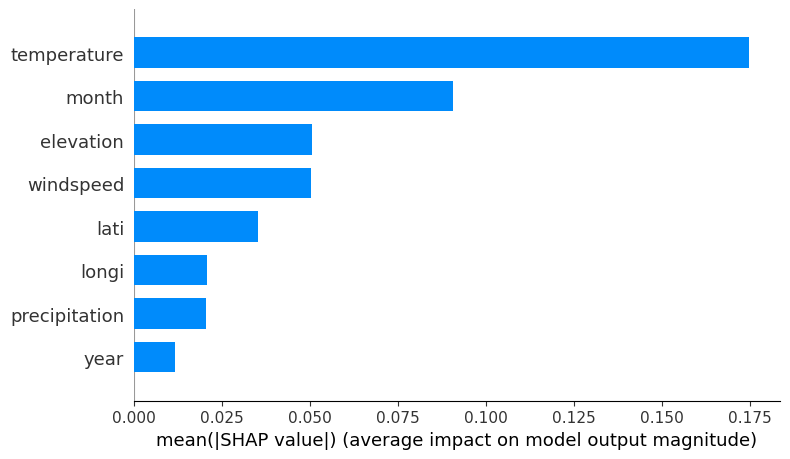

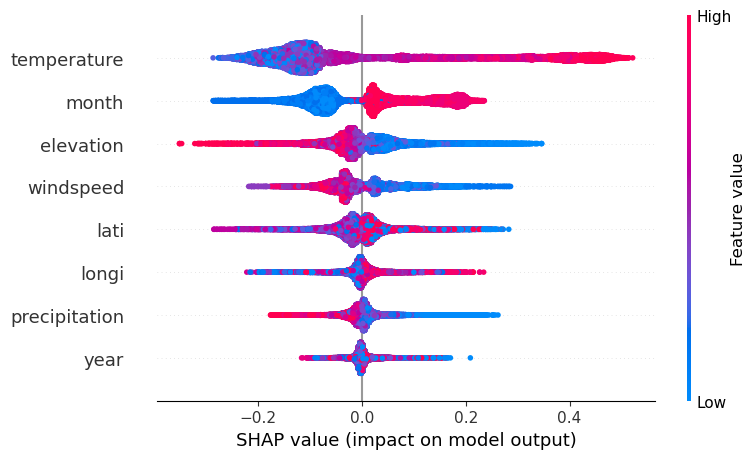



SHAP decision plot


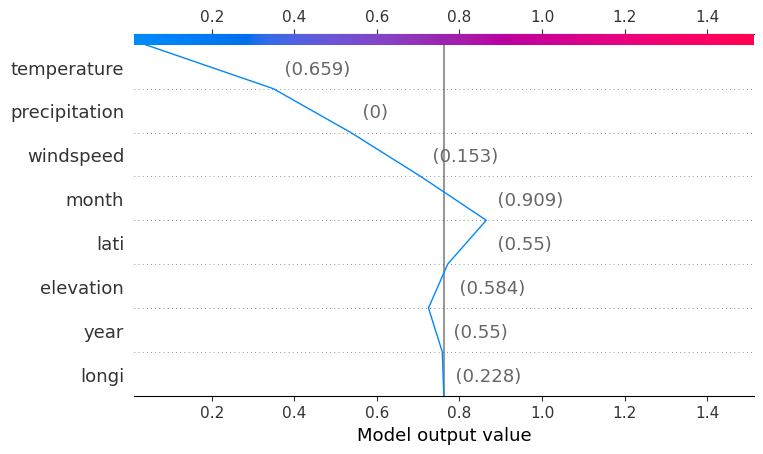



SHAP force plot


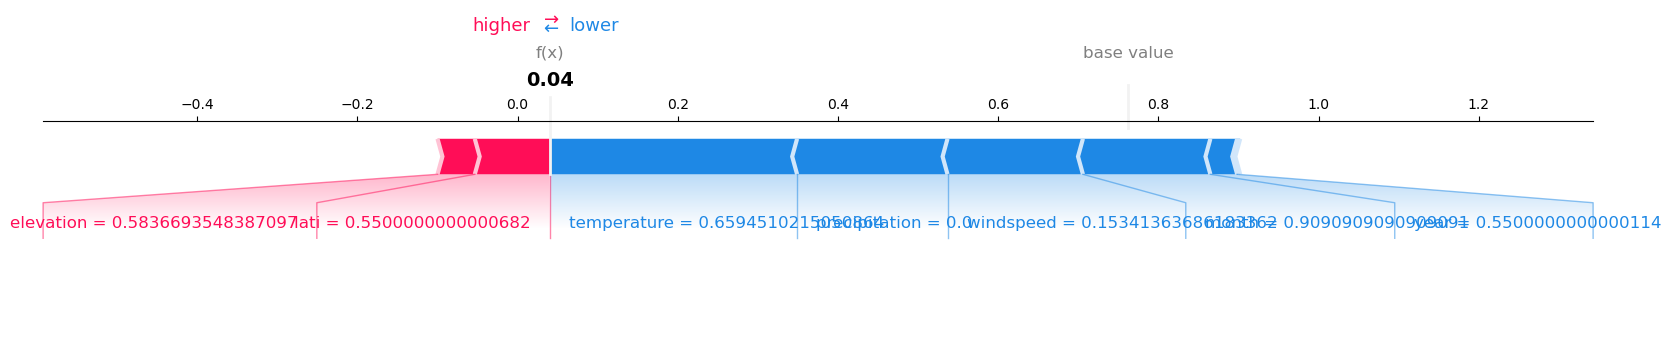



SHAP waterfall plot


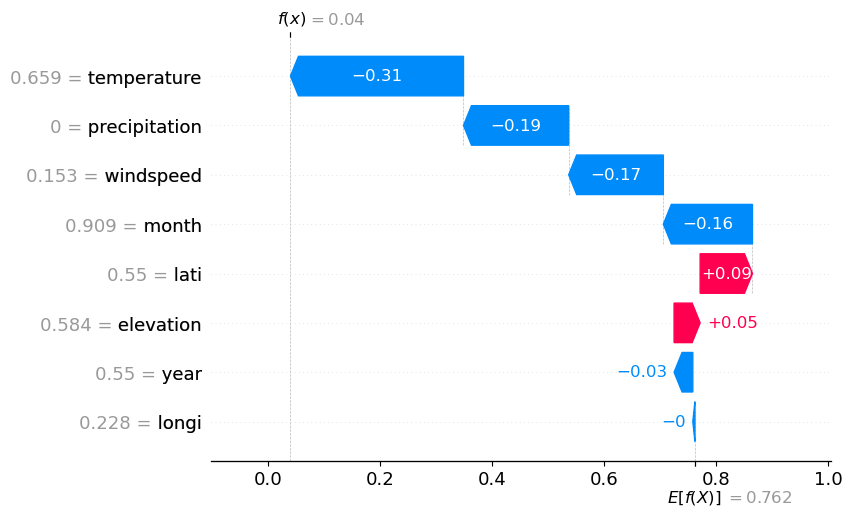



LIME explanation


C:\Users\ashiq\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\ashiq\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\ashiq\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, 

In [1]:
#import libraries
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import lime
import lime.lime_tabular

import shap
shap.initjs()

# Step 2: Load Data
data = pd.read_csv("D:\\GEE\\Zugspitze\\combined\\allmerged.csv")

# Rename columns x and y to longi and lati
data = data.rename(columns={'x': 'longi', 'y': 'lati'})

data.head(10)

print(f'Size of the dataset: {data.shape}')

#Create new column 'new_label' where snow cover value <= 20 will be considered as 0 and others 1
data['new_label'] = data['snow cover'].apply(lambda x: 0 if x <= 20 else 1 )

#input features
X = data.drop(columns=['snow cover','new_label'])

#level features
y = data['new_label'] 

#split the dataset into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

print(f"Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}, Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}")

# Perform Min-Max scaling on X
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

#ceate the model with best parameters
rfcf = RandomForestClassifier(n_estimators = 50, min_samples_split = 2, 
                             min_samples_leaf= 1, max_features = 'log2', 
                             max_depth= 40, bootstrap=False, 
                             n_jobs = -1, random_state=35)


rfcf.fit(X_train, y_train)

#Predict the model
y_pred = rfcf.predict(X_test)

#Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print("\n\nAccuracy:", accuracy)

# Generate classification report
cr = classification_report(y_test, y_pred, target_names=['no snowcover', 'snowcover'])
print("\n\nClassification Report:\n\n", cr)

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\n\nConfusion matrix:\n\n", cm)
print("\n")
# visualize confusion matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(cm.shape[0], cm.shape[1])

sns.heatmap(cm, annot=labels, fmt='', cmap="crest",
           xticklabels=['no snowcover', 'snowcover'],
           yticklabels =['no snowcover', 'snowcover'])

# display matrix
plt.ylabel('Actual',fontsize=12)
plt.xlabel('Prediction',fontsize=12)
plt.show()

#Shap interpretation
explainer = shap.TreeExplainer(rfcf)
shap_values = explainer.shap_values(X_test)

X_set = pd.DataFrame (X_test, columns = ['longi', 'lati', 'year', 'month', 'precipitation', 'temperature', 'windspeed',
       'elevation'])

#Summary Plot
print("\n\nSHAP summary plot: Features importance")
shap.summary_plot(shap_values[:,:,0], X_set, plot_type="bar")
print("\n")
shap.summary_plot(shap_values[:,:,0], X_set[:])

#Decision Plot
print("\n\nSHAP decision plot")
shap.decision_plot(explainer.expected_value[1], shap_values[3,:,1], X_set.iloc[3]) # Here expected_value[1] means Snow. If the output value shows 0 means No snow and 1 means snow. Similarly expected_value[0] means No Snow. If the output value shows 0 means snow and 1 means No snow  
                                                                                  # Here shap_values[3,:,1] --> 3 means 4th row value output value and 1 means Snow like expected_value[1]
#Force Plot
print("\n\nSHAP force plot")
shap.plots.force(explainer.expected_value[1], shap_values[3,:,1], X_set.iloc[3], matplotlib = True)

#Waterfall plot
print("\n\nSHAP waterfall plot")
shap.waterfall_plot(shap.Explanation(values=shap_values[3,:,1], 
                                              base_values=explainer.expected_value[1], data=X_set.iloc[3],  
                                         feature_names=X_set.columns.tolist()))

print("\n\nLIME explanation")
# Get the class names
class_names = ['No Snow', 'Snow']

# Get the feature names
feature_names = ['longi', 'lati', 'year', 'month', 'precipitation', 'temperature', 'windspeed', 'elevation']

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainerL = lime.lime_tabular.LimeTabularExplainer (X_train, feature_names = feature_names,
                                  class_names = class_names,
                                  mode = 'classification')

#Explaining Instance 
exp = explainerL.explain_instance(X_set.iloc[3], rfcf.predict_proba)

exp.show_in_notebook(show_all = True)
